<a href="https://colab.research.google.com/github/Kac1509/ZebrafishClassifier/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import sys
import os

#Set if running locally or in Google Colaboratory
Colab = True
if Colab:
    Script_path = '/content/gdrive/My Drive/Colab Notebooks/Classifier/scripts'
    Base_path = '/content/gdrive/My Drive/Colab Notebooks/Classifier/'
    from google.colab import drive
    drive.mount('/content/gdrive')
else:
    Script_path = os.getcwd() + '/Classifier/scripts'
    Base_path = 'Classifier/'

#Add script folder to system path
sys.path.insert(0, Script_path)
print(sys.path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['/content/gdrive/My Drive/Colab Notebooks/Classifier/scripts', '/content/gdrive/My Drive/Colab Notebooks/Classifier/scripts', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [14]:
%load_ext autoreload
%autoreload 2

from build_model_RMSprop import *
from create_data_generators import *
from createFolders import *
from createSets import *
from GenotypeClass import *
from load_pre_trained_VGG16 import *
from load_pre_trained_Inception import *
from model_prediction import *
from plot_loss_acc import *
from predictClass import *
from saveFiles import *
from unzip_data import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
#Name of the data zipfile
Data_file = 'DataStraightened.zip'

#Set Paths
Zip_path = Base_path + Data_file
Extracted_path = Base_path + 'ExtractedData/'
Partitioned_path = Base_path + 'PartitionedData/'
Prediction_path = Base_path + 'Predictions/'
Validation_prediction_path = Base_path + 'Validation_Predictions/'


In [0]:
#Specify input parameters for the pre_trained model
shapeY = 50
shapeX = 50
color_channels = 3

# Loading pre-trained models

#VGG16 Model
local_weights_file_VGG16 = Base_path + 'weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model_VGG16, last_layer_output_VGG16 = load_pre_trained_VGG16(local_weights_file_VGG16, shapeY, shapeX, color_channels)

# Inception Model
#local_weights_file_Inception = Base_path + 'weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
#pre_trained_model_Inception, last_layer_output_Inception = load_pre_trained_Inception(local_weights_file_Inception, shapeY, shapeX, color_channels)


In [0]:
#Clear Folders and create Prediction folder
deleteFiles(Extracted_path)
deleteFiles(Partitioned_path)
createFolder(Prediction_path)


In [0]:
#Extract Data
unzip_data(Zip_path, Extracted_path)

In [19]:

Genotypes = []
num_classes = len(glob.glob(Extracted_path+'*'))
for i in range(num_classes):
        #Retrieve directory for a given type
        Genotype_name = os.listdir(Extracted_path)[i]
        Genotypes.append(Genotype(Genotype_name))
print(num_classes)
createDirectories(num_classes,Extracted_path,Partitioned_path,Genotypes)


3


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1359x150 at 0x7F1960514D30>


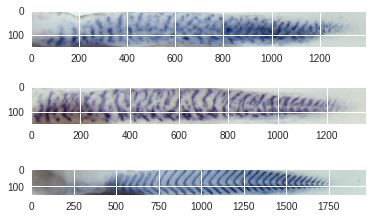

In [20]:
#Sample Image 
print(Genotypes[1].images[0])
plt.subplot(311)
plt.imshow(Genotypes[0].images[0])
plt.subplot(312)
plt.imshow(Genotypes[1].images[0])
plt.subplot(313)
plt.imshow(Genotypes[2].images[0])

In [0]:
def runModel(epochs = 2, num_nodes = 1024, lr = 0.00001):
    #Save partitions to respective folder
    saveFiles(Genotypes)
    
    # Creating training and validation data generators from separated data
    # Transformations are for training generator only

    train_generator, validation_generator = create_data_generators(
        Partitioned_path,
        shapeY, shapeX, 
        train_batch_size=len(Genotypes[0].trainSet), 
        validation_batch_size=len(Genotypes[0].testSet),
        class_mode='categorical',
        horizontal_flip = False)#,
        #rotation_range=30,
        #width_shift_range=0.3,
        #height_shift_range=0.3,
        #shear_range=0.3,
        #zoom_range=0.3)
    
    x_batch, y_batch = next(train_generator)
    xtest_batch, ytest_batch = next(validation_generator)
    print(y_batch.shape)
    print(ytest_batch.shape)
        
        # Building model
    learning_rate = lr
    hidden_units_num = num_nodes
    dropout_rate = 0.5 #"rate=0.1" would drop out 10% of input units.
    model = build_model_RMSprop(pre_trained_model_VGG16, last_layer_output_VGG16, 
                            Dropout = False,
                            dropout_rate = dropout_rate, 
                            learning_rate = learning_rate ,
                            hidden_units_num = hidden_units_num,
                            num_classes=num_classes,
                            activation = 'softmax')
    
    # Training model

    history = model.fit_generator(
      train_generator,
      steps_per_epoch=3,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=3,
      verbose=2)
    
    return Genotypes,history,model

In [0]:
from sklearn.model_selection import KFold
from operator import itemgetter



def CV_run(Genotypes_Fold,History_Fold,Model_Fold,epochs,n_splits = 2, num_nodes = 1024, lr = 0.00001):
    idx,size = retrieveSmall(Genotypes,sys.maxsize)
    kf = KFold(n_splits=n_splits, shuffle=True)
    kf.get_n_splits(Genotypes[idx].images)
    #print( Genotypes[0].images[0])  
    Fold = 0;
 
    for train_index, test_index in kf.split(Genotypes[idx].images):

        #print("Fold: ", Fold," train_index: ",train_index)
        print("Fold: ", Fold," test_index: ",test_index)
        #deleteFiles(Base_path + 'PartitionedData')
        createDirectories(num_classes,Extracted_path,Partitioned_path,Genotypes)

        for i in range(len(Genotypes)):
            Genotypes[i].trainSet = itemgetter(*train_index)(Genotypes[i].images)
            Genotypes[i].testSet = itemgetter(*test_index)(Genotypes[i].images)
            #print("Train_set size: ", len(Genotypes[i].trainSet), " Test_set size: ",len(Genotypes[i].testSet))
            
        Gen,Hist,Mdl = runModel(epochs, num_nodes = num_nodes, lr = lr)
        Genotypes_Fold.append(Gen),History_Fold.append(Hist),Model_Fold.append(Mdl) 
        
        Fold+=1
        #plt.subplot(n_splits, 1, Fold)
        #plt.imshow(Genotypes[2].testSet[0])
        print(len(Genotypes[i].trainSet))


In [0]:
CV = True

#Run Cross-Validation or a single run 
if CV:
    Genotypes_Fold = []
    History_Fold = []
    Model_Fold = []
    CV_run(Genotypes_Fold,History_Fold,Model_Fold,epochs=2,n_splits = 7)
else:
    #Partition data into training and test set
    #If fixed set to true, all training and test sets have the same size for all classes 
    createDirectories(num_classes,Extracted_path,Partitioned_path,Genotypes)
    createTrain_Test(Genotypes,0.3, fixed = True)
    Gen,Hist,Mdl = runModel(epochs=2)


31
76
33
Fold:  0  test_index:  [ 2  7 10 21 30]
Found 78 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
(26, 3)
(5, 3)
Epoch 1/2
 - 4s - loss: 0.6833 - acc: 0.6026 - val_loss: 0.6600 - val_acc: 0.6444
Epoch 2/2
 - 1s - loss: 0.6680 - acc: 0.5940 - val_loss: 0.6492 - val_acc: 0.6222
26
Fold:  1  test_index:  [12 16 24 25 28]
Found 78 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
(26, 3)
(5, 3)
Epoch 1/2
 - 2s - loss: 0.6173 - acc: 0.6667 - val_loss: 0.5904 - val_acc: 0.6667
Epoch 2/2
 - 1s - loss: 0.6076 - acc: 0.6667 - val_loss: 0.5841 - val_acc: 0.6667
26
Fold:  2  test_index:  [ 4  5  8 18 22]
Found 78 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
(26, 3)
(5, 3)
Epoch 1/2
 - 2s - loss: 0.6888 - acc: 0.5513 - val_loss: 0.6637 - val_acc: 0.6000
Epoch 2/2
 - 1s - loss: 0.6701 - acc: 0.6154 - val_loss: 0.6514 - val_acc: 0.7333
26
Fold:  3  test_index:  [13 15 19 20]
Found 81 images belonging to 3 classes.
Found 13

7
[0.644444465637207, 0.6222222447395325]
[0.6666666865348816, 0.6666666865348816]
[0.5999999940395355, 0.7333333492279053]
[0.6666666865348816, 0.6666666865348816]
[0.5277777910232544, 0.5833333532015482]
[0.7222222288449606, 0.694444457689921]
[0.6666666865348816, 0.6666666865348816]


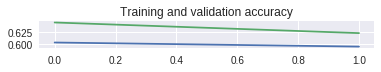

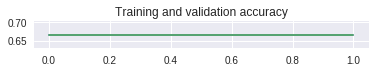

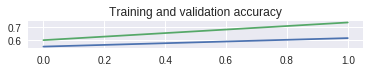

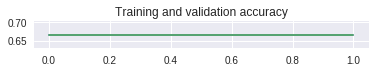

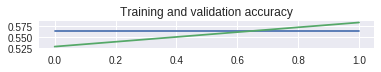

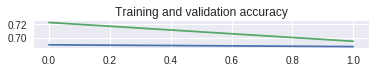

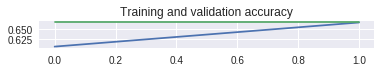

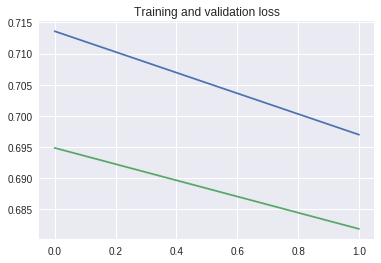

In [0]:
#Plotting Accuracy for folds
if CV:
    print(len(History_Fold))
    for i in range(len(History_Fold)):
        print(History_Fold[i].history['val_acc'])
        plt.subplot(len(History_Fold), 1, i+1)
        plot_loss_acc(History_Fold[i])
#Plotting for single run
else:
    plot_loss_acc(Hist)
    

In [0]:
#Format array to 4 decimal points
float_formatter = lambda x: "%.4f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

#Predict Model based on validation set

model_prediction(
    model, 
    Genotypes,
    Validation_prediction_path,
    shapeY, shapeX, 
    class_mode = 'categorical' # If the content of class0_test_path and class1_test_path should be refreshed
    )

Found 15 images belonging to 1 classes.
15/15 [==============================] - 1s 59ms/step
fsstbx6s
[[0.2801 0.3723 0.3476]
 [0.2929 0.3980 0.3090]
 [0.2655 0.3821 0.3524]
 [0.2827 0.3641 0.3532]
 [0.2142 0.4590 0.3268]
 [0.2459 0.4088 0.3453]
 [0.2090 0.4222 0.3688]
 [0.2541 0.3361 0.4099]
 [0.2473 0.4437 0.3090]
 [0.1948 0.4846 0.3205]
 [0.2583 0.3859 0.3557]
 [0.2529 0.4057 0.3414]
 [0.2411 0.3966 0.3622]
 [0.2569 0.3739 0.3692]
 [0.2623 0.3687 0.3690]]
Found 15 images belonging to 1 classes.
15/15 [==============================] - 1s 58ms/step
her1her7s
[[0.2606 0.3588 0.3806]
 [0.2271 0.4031 0.3698]
 [0.2444 0.3865 0.3691]
 [0.2701 0.3618 0.3680]
 [0.1815 0.4531 0.3654]
 [0.1918 0.4264 0.3818]
 [0.2450 0.4478 0.3072]
 [0.2705 0.3480 0.3815]
 [0.2272 0.3830 0.3898]
 [0.2688 0.3355 0.3957]
 [0.1764 0.4478 0.3758]
 [0.2188 0.3840 0.3972]
 [0.2679 0.3493 0.3828]
 [0.2392 0.3802 0.3806]
 [0.1849 0.4218 0.3933]]
Found 15 images belonging to 1 classes.
15/15 [========================

In [0]:
predictionFiles, predictions = predictClass(model,Prediction_path, shapeY, shapeX, class_mode='categorical')
#print(predictions)
for i in range(len(predictions)):
    print(predictionFiles.filenames[i])
    print(predictions[i])

Found 0 images belonging to 0 classes.


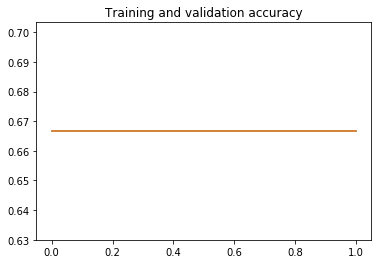

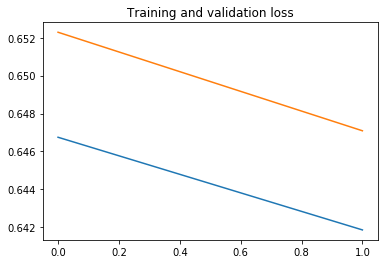

In [0]:
#Plot training and validation accuracy per epoch

plot_loss_acc(history)

In [0]:
import csv
import datetime

ModelType = 'Prediction_Model_1_Option1_' 
time = f"{datetime.datetime.now():%Y-%m-%d_%H%M}"
csvName = ModelType + time + '.csv'
PredictionCSV = Base_path + csvName
with open(PredictionCSV, 'w') as csvfile:
    fieldnames = ['Filename', 'WT', 'FSS', 'HH']
    writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames,lineterminator = '\n')
    writer.writeheader()
    for i in range(len(predictions)):
        writer.writerow({'Filename':str(predictionFiles.filenames[i]),'WT':float(format(predictions[i][0], '.4f')),'FSS':float(format(predictions[i][1], '.4f')),'HH':float(format(predictions[i][2], '.4f'))})
    Model_parameters = model.optimizer,", Learning Rate:", learning_rate, ", Hidden_Units:", hidden_units_num, "Input_size:", model.inputs
    writer.writerow({'Filename':"Model",'WT':str(Model_parameters)})
    

**Hyper params tuning**

In [0]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_loss(history, lr):
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get number of epochs
  epochs = range(len(loss))

  # Plot training and validation loss per epoch
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  plt.title('Training and validation loss, lr = ' + str(lr))

  plt.figure()

In [0]:
import numpy as np
import matplotlib.pyplot as plt


def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("learning rate")
    plt.ylabel("loss")
    plt.title("different learning rates")
    plt.legend(loc=2)
    plt.grid(True)
    # plt.savefig("cross_validation")

In [25]:
def learning_rate_demo():
    seed = 12
    # degree = 7
    k_fold = 4
    learning_rates = np.logspace(-7, -2, 7)
    # split data in k fold
    # k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    loss_tr = []
    loss_te = []
    # cross validation
    for lr in learning_rates:
        print('lr = ' + str(lr))
        
        Genotypes_Fold = []
        History_Fold = []
        Model_Fold = []
        CV_run(Genotypes_Fold, History_Fold, Model_Fold, epochs=20, n_splits = k_fold, num_nodes = 1024, lr = lr)
        
        loss_tr_tmp = []
        loss_te_tmp = []
        for i in range(k_fold):
          #plot_loss(history, lr)
          loss_tr_tmp.append(History_Fold[0].history['loss'][-1])
          loss_te_tmp.append(History_Fold[0].history['val_loss'][-1])
        loss_tr.append(np.mean(loss_tr_tmp))
        loss_te.append(np.mean(loss_te_tmp))

    cross_validation_visualization(learning_rates, loss_tr, loss_te)

learning_rate_demo()

lr = 1e-07
31
76
33
Fold:  0  test_index:  [ 1  9 11 15 19 26 27 29]
Found 69 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
(23, 3)
(8, 3)
Epoch 1/20
 - 5s - loss: 0.7231 - acc: 0.5507 - val_loss: 0.7409 - val_acc: 0.5139
Epoch 2/20


KeyboardInterrupt: ignored

In [0]:
def hidden_nodes_demo():
    seed = 12
    # degree = 7
    k_fold = 4
    hidden_nodes = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
    lr = 0.001
    # split data in k fold
    # k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    loss_tr = []
    loss_te = []
    # cross validation
    for nodes in hidden_nodes:
        print('nodes = ' + str(nodes))
        
        Genotypes_Fold = []
        History_Fold = []
        Model_Fold = []
        CV_run(Genotypes_Fold, History_Fold, Model_Fold, epochs=10, n_splits = k_fold, num_nodes = nodes, lr = lr)
        
        loss_tr_tmp = []
        loss_te_tmp = []
        for i in range(k_fold):
          #plot_loss(history, lr)
          loss_tr_tmp.append(History_Fold[0].history['loss'][-1])
          loss_te_tmp.append(History_Fold[0].history['val_loss'][-1])
        loss_tr.append(np.mean(loss_tr_tmp))
        loss_te.append(np.mean(loss_te_tmp))

    cross_validation_visualization(hidden_nodes, loss_tr, loss_te)

hidden_nodes_demo()

nodes = 4
31
76
33
Fold:  0  test_index:  [ 1  4  5  9 13 14 26 28]
Found 69 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
(23, 3)
(8, 3)
Epoch 1/10
 - 3s - loss: 0.6163 - acc: 0.6667 - val_loss: 0.5872 - val_acc: 0.6806
Epoch 2/10
 - 1s - loss: 0.5719 - acc: 0.6908 - val_loss: 0.5505 - val_acc: 0.7361
Epoch 3/10
 - 1s - loss: 0.5489 - acc: 0.7198 - val_loss: 0.5362 - val_acc: 0.7361
Epoch 4/10
 - 1s - loss: 0.5371 - acc: 0.7295 - val_loss: 0.5245 - val_acc: 0.7222
Epoch 5/10
 - 1s - loss: 0.5190 - acc: 0.7295 - val_loss: 0.5137 - val_acc: 0.7222
Epoch 6/10
 - 1s - loss: 0.5059 - acc: 0.7391 - val_loss: 0.5045 - val_acc: 0.7361
Epoch 7/10
 - 1s - loss: 0.4953 - acc: 0.7488 - val_loss: 0.4948 - val_acc: 0.7361
Epoch 8/10
 - 1s - loss: 0.4893 - acc: 0.7391 - val_loss: 0.4869 - val_acc: 0.7500
Epoch 9/10
 - 1s - loss: 0.4796 - acc: 0.7585 - val_loss: 0.4794 - val_acc: 0.7500
Epoch 10/10
 - 1s - loss: 0.4671 - acc: 0.7536 - val_loss: 0.4740 - val_acc: 0.7639
23
Fol

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)